In [2]:
import tushare as ts
import pandas as pd
import time

# Initialize Tushare API
ts.set_token('your_token')
pro = ts.pro_api()

# Get 510050.SH option data for 1-month period
start_date = '20250515'
end_date = '20250613'
ts_code1 = '10009222.SH'  # Buy Call 2.75 strike
ts_code2 = '10009317.SH'  # Sell Call 3.00 strike

# Fetch option data
price1 = pro.opt_daily(ts_code=ts_code1, start_date=start_date, end_date=end_date)
time.sleep(1)
price2 = pro.opt_daily(ts_code=ts_code2, start_date=start_date, end_date=end_date)

# Find common dates and calculate spreads
dates1 = set(price1['trade_date'])
dates2 = set(price2['trade_date'])
common_dates = sorted(list(dates1 & dates2))

spreads = []
for date in common_dates:
    close1 = price1[price1['trade_date'] == date]['close'].values[0]
    close2 = price2[price2['trade_date'] == date]['close'].values[0]
    spreads.append(close1 - close2)

# 1- month holding period simulation
initial_spread = spreads[0]
final_spread = spreads[-1]
total_pnl = final_spread - initial_spread

print(f"1-Month Holding Period Results:")
print(f"Initial spread: {initial_spread:.4f} ¥")
print(f"Final spread: {final_spread:.4f} ¥")
print(f"Total P&L: {total_pnl:.4f} ¥")
# Expected profit under 3 scenarios
K1, K2 = 2.75, 3.00
net_premium = initial_spread

scenarios = {'Bull': 3.20, 'Base': 2.90, 'Bear': 2.50}

print(f"\nExpected Profit Under 3 Scenarios:")
for name, S in scenarios.items():
    payoff = max(0, min(S - K1, K2 - K1)) - net_premium
    print(f"{name} scenario (Price {S}): {payoff:.4f} ¥")

# Backtest using historical data
daily_returns = [(spreads[i] - spreads[i-1])/spreads[i-1] for i in range(1, len(spreads))]
total_return = (final_spread/initial_spread - 1) * 100
win_rate = sum(1 for x in daily_returns if x > 0) / len(daily_returns) * 100

print(f"\nBacktest Results:")
print(f"Total return: {total_return:.2f}%")
print(f"Win rate: {win_rate:.1f}%")
print(f"Trading days: {len(common_dates)}")

# Volatility sensitivity analysis
vol_scenarios = [-0.20, -0.10, 0.00, 0.10, 0.20]

print(f"\nVolatility Sensitivity Analysis:")
for vol_change in vol_scenarios:
    new_spread = final_spread * (1 + vol_change * 0.5)
    impact = new_spread - final_spread
    print(f"Vol {vol_change*100:+.0f}%: Impact = {impact:+.4f} ¥")




1-Month Holding Period Results:
Initial spread: 0.0962 ¥
Final spread: 0.0820 ¥
Total P&L: -0.0142 ¥

Expected Profit Under 3 Scenarios:
Bull scenario (Price 3.2): 0.1538 ¥
Base scenario (Price 2.9): 0.0538 ¥
Bear scenario (Price 2.5): -0.0962 ¥

Backtest Results:
Total return: -14.76%
Win rate: 35.0%
Trading days: 21

Volatility Sensitivity Analysis:
Vol -20%: Impact = -0.0082 ¥
Vol -10%: Impact = -0.0041 ¥
Vol +0%: Impact = +0.0000 ¥
Vol +10%: Impact = +0.0041 ¥
Vol +20%: Impact = +0.0082 ¥


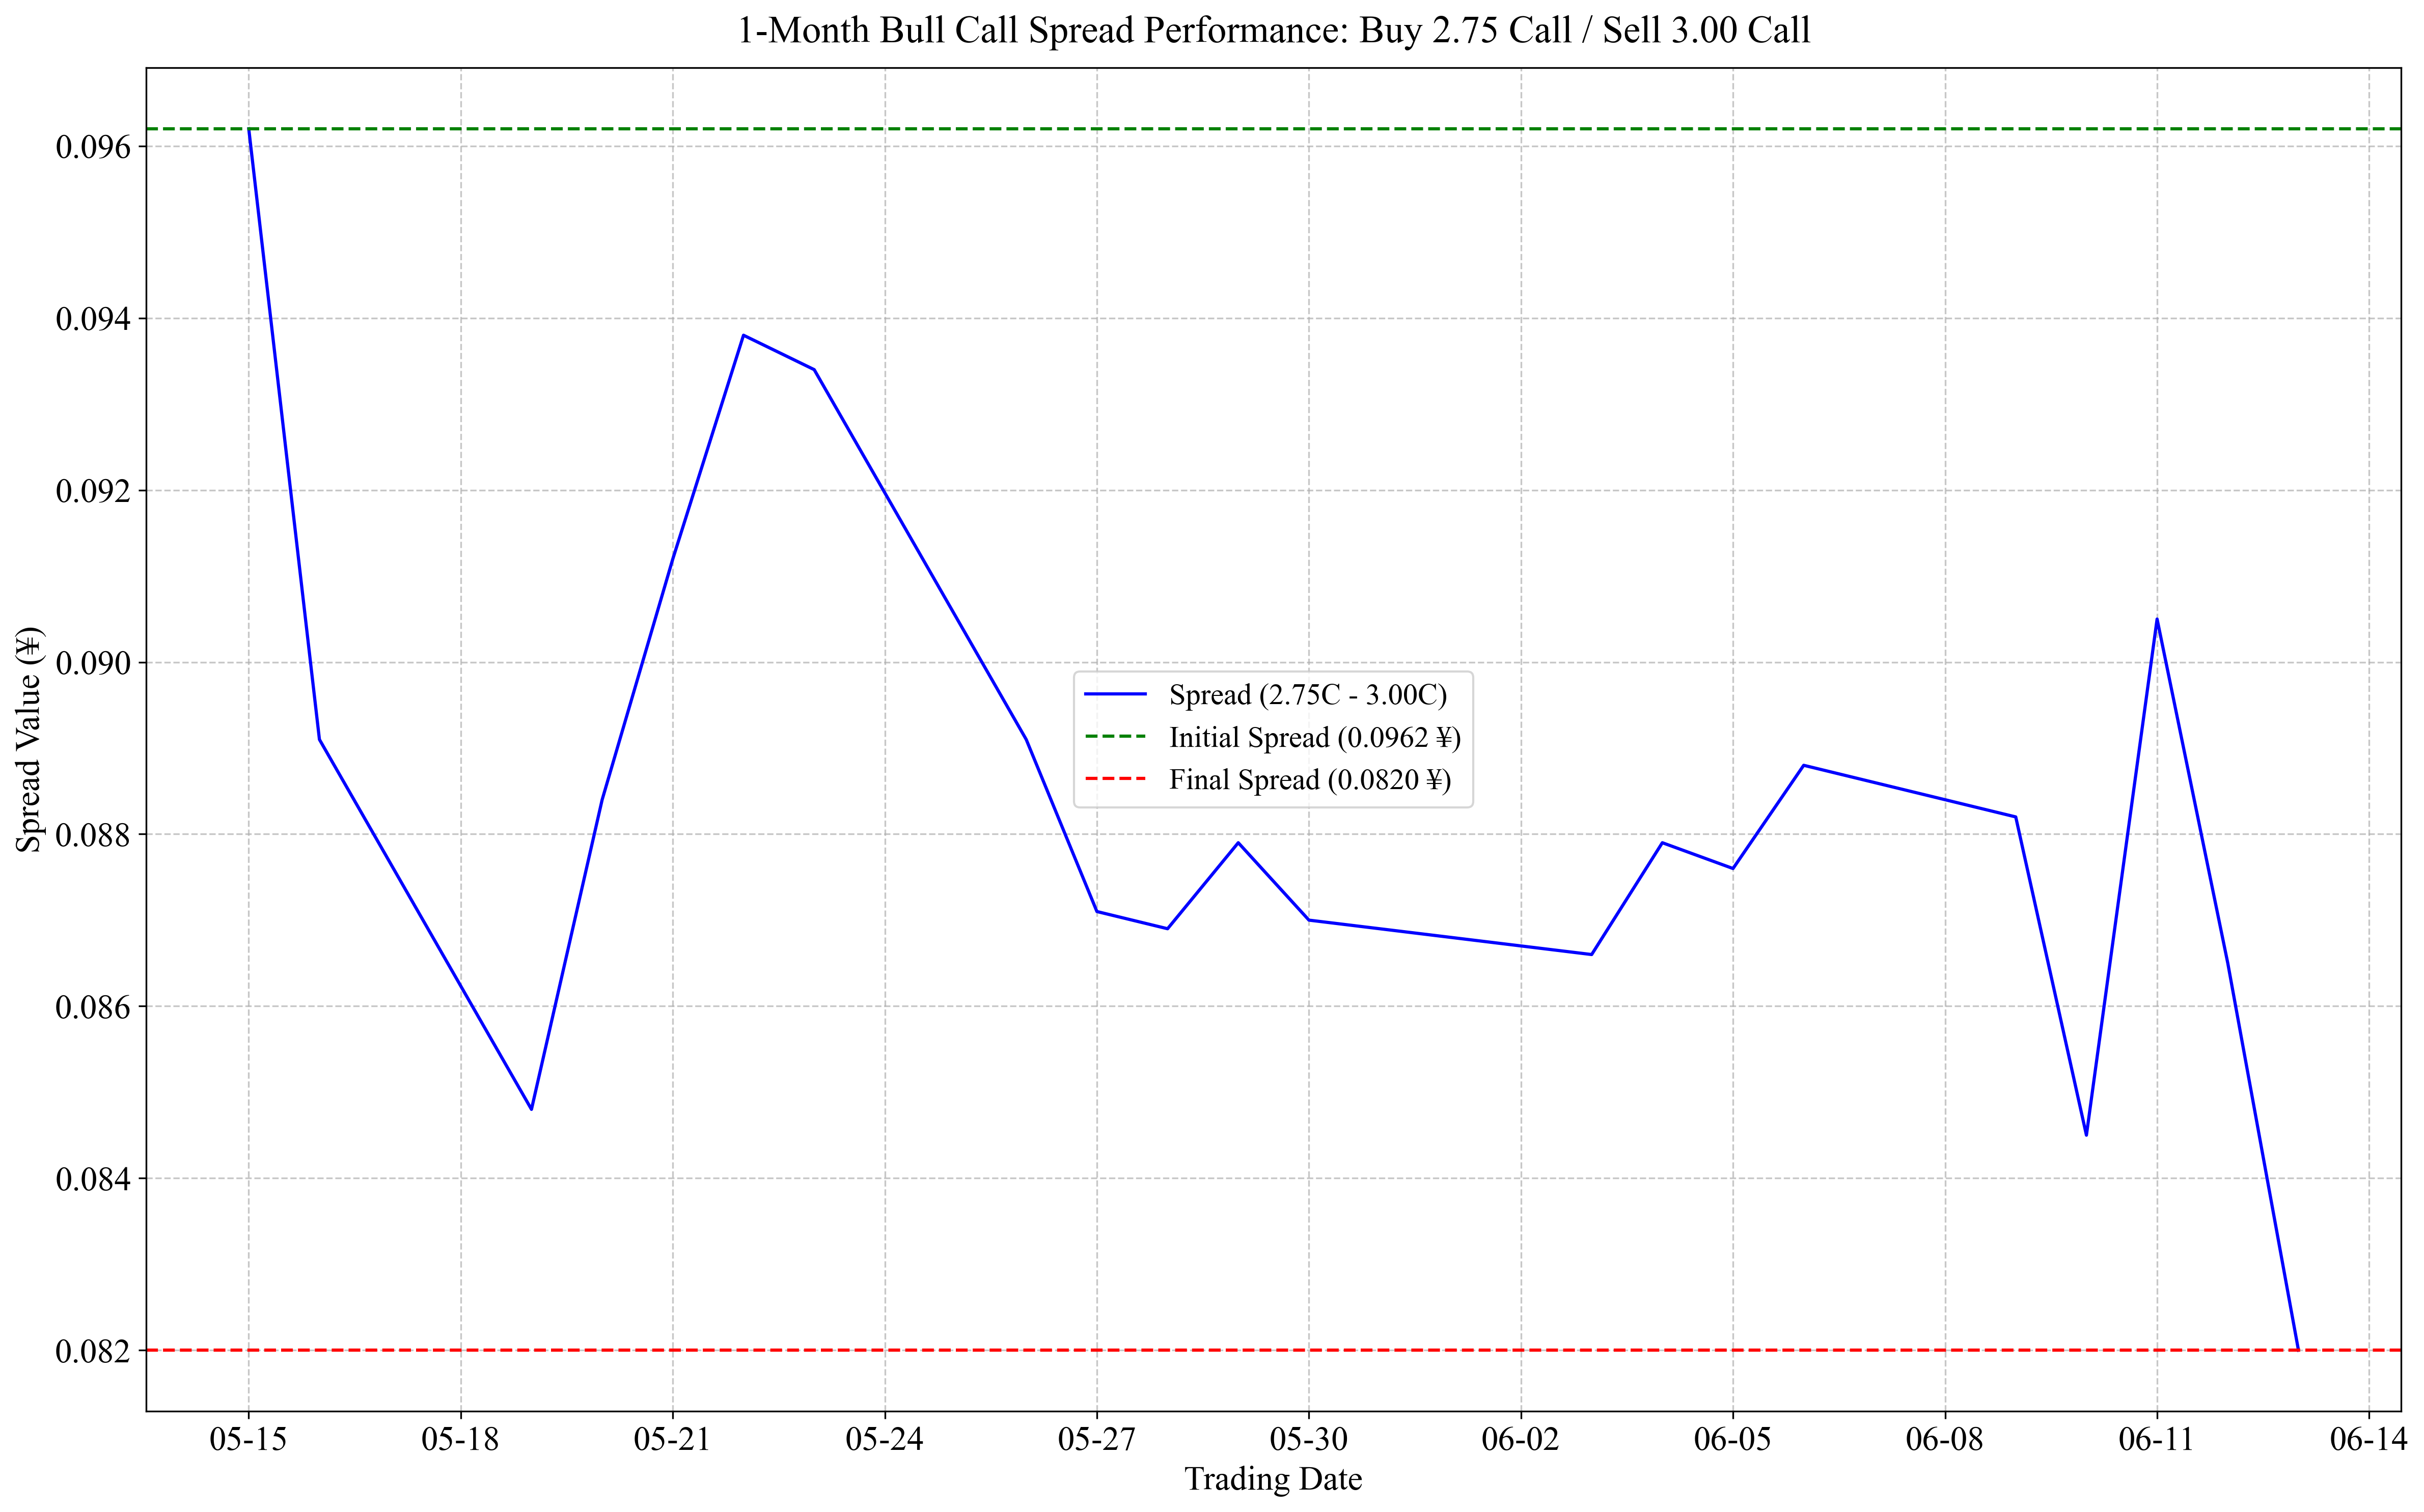

Length of common_dates: 21, Length of spreads: 21
Sample common_dates: [datetime.datetime(2025, 5, 15, 0, 0), datetime.datetime(2025, 5, 16, 0, 0), datetime.datetime(2025, 5, 19, 0, 0), datetime.datetime(2025, 5, 20, 0, 0), datetime.datetime(2025, 5, 21, 0, 0)]
Sample spreads: [0.09620000000000001, 0.08910000000000001, 0.08480000000000001, 0.08839999999999999, 0.0912]


In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

plt.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(16, 10), dpi=300)

if all(isinstance(date, str) for date in common_dates):
    common_dates = [datetime.strptime(date, '%Y%m%d') for date in common_dates]
elif not all(isinstance(date, datetime) for date in common_dates):
    raise ValueError("common_dates contains mixed or unsupported date types. Check your data!")

plt.plot(common_dates, spreads, label="Spread (2.75C - 3.00C)", linewidth=1.5, color='blue')

plt.axhline(initial_spread, linestyle='--', color='green', linewidth=1.5, label=f'Initial Spread ({initial_spread:.4f} ¥)')
plt.axhline(final_spread, linestyle='--', color='red', linewidth=1.5, label=f'Final Spread ({final_spread:.4f} ¥)')

plt.title("1-Month Bull Call Spread Performance: Buy 2.75 Call / Sell 3.00 Call", fontsize=18, pad=12)
plt.xlabel('Trading Date', fontsize=16)
plt.ylabel('Spread Value (¥)', fontsize=16)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=14, loc='best')

plt.tight_layout()

plt.show()

print(f"Length of common_dates: {len(common_dates)}, Length of spreads: {len(spreads)}")
print(f"Sample common_dates: {common_dates[:5]}")
print(f"Sample spreads: {spreads[:5]}")